In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Pakete

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import scipy.stats
#from scipy.stats import wilcoxon
import time
import shap
import xgboost
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Optimale Parameter
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

#SVM
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib import cm

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score




# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Interpretation
import shap
shap.initjs()


In [2]:

# testdaten für die presi holen
import os
os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

df = pd.read_csv('data/aidsenc.csv', sep =",")

In [3]:
df.shape

(2139, 17)

In [4]:
df.columns

Index(['Unnamed: 0', 'age', 'cd40', 'cid', 'trt_1', 'trt_2', 'trt_3', 'homo_1',
       'drugs_1', 'z30_1', 'gender_1', 'strat_2', 'strat_3', 'symptom_1',
       'hemo_1', 'race_1', 'ecog_1'],
      dtype='object')

In [5]:
# für weitere Tables 'Unnamed' Nummerierung enfernen
df = df.drop(["Unnamed: 0"],axis=1) #,"hemo", "race", "ecog"

In [6]:
df.head(5)

,age,cd40,cid,trt_1,trt_2,trt_3,homo_1,drugs_1,z30_1,gender_1,strat_2,strat_3,symptom_1,hemo_1,race_1,ecog_1
0,48,422,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,61,162,1,0,0,1,0,0,1,0,0,1,0,0,0,0
2,45,326,0,0,0,1,1,1,1,1,0,1,0,0,0,0
3,47,287,0,0,0,1,1,0,1,1,0,1,0,0,0,0
4,43,504,0,0,0,0,1,0,1,1,0,1,0,0,0,0


In [7]:
# df1-Datensatz für erste Modellrechnungen erstellen, der unveränderter, encodeder df-Datensatz kann im Verlauf aufgerufen werden
df1 = df

# Datensplitting

In [8]:
X=df1.drop(['cid'],axis=1)
y=df1['cid']

In [9]:
X_fintrain, X_fintest, y_fintrain, y_fintest = train_test_split(X, y, shuffle=True, test_size=0.2,random_state=42)

print('X Train groß: {}'.format(X_fintrain.shape)) 
print('Y Train groß: {}'.format(y_fintrain.shape)) 
print('X Test final: {}'.format(X_fintest.shape)) 
print('Y Test final: {}'.format(y_fintest.shape))


X Train groß: (1711, 15)
Y Train groß: (1711,)
X Test final: (428, 15)
Y Test final: (428,)


# Transformierung mit MinMaxScaler

Die Entscheidung für die Normalisierung (und nicht die Standardisierung) wurde in Anbetracht der Ungewissheit, wie die unbekannten, neuen Test-Daten verteilt werden würden, getroffen.

Es werden nur die Daten für das Training normalisiert. 

Für Ausblick: In piplines können sowohl Trainings- als auch Testdaten normalisiert werden. 

## Scaler fitten

Das ist zugegeben eine unschöne Lösung. Der Scaler wird auf den Daten 1. Splits gefittet und die numerischen Features gleich transformiert.
Schöner wäre es, den Scaler auf numerische Features zu fitten und über pipelines beliebeg auf Daten mit scaler.transform() anwenden. 

In [10]:
#from sklearn.preprocessing import MinMaxScaler
mscaler = MinMaxScaler()

X_fintrain['age'] = mscaler.fit_transform(X_fintrain['age'].to_numpy().reshape(-1,1))
X_fintrain['cd40'] = mscaler.fit_transform(X_fintrain['cd40'].to_numpy().reshape(-1,1))

# Erstellen des Validierungsdatensatzes

Der Trainingsdatensatz wird noch ein mal geteilt, um während der Trainingsphase einen Validierungsdatensatz zu haben.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_fintrain, y_fintrain, shuffle=True, test_size=0.2,random_state=42)

print('X Train klein: {}'.format(X_train.shape)) 
print('Y Train klein: {}'.format(y_train.shape)) 
print('X Validierung: {}'.format(X_test.shape)) 
print('Y Validierung: {}'.format(y_test.shape))

X Train klein: (1368, 15)
Y Train klein: (1368,)
X Validierung: (343, 15)
Y Validierung: (343,)


In [12]:
X_train1 = X_train.copy()
X_test1 = X_test.copy()
y_train1 = y_train.copy()
y_test1 = y_test.copy()

# Hyperparameter

Die Suche nach optimalen `C`, `gamma`, `kernel`, `max_depth` und `n_estimators` wurde mittels Random_Search durchgeführt. GRID-Research und Cross-Validierung dauerte zu lange. 

Per default ist Gamma 'scale', i.e. gamma = 1 / (n_features * X.var()). <span style=color:green>Vorweg:</span> Es wird überlegt, die `gamma`='scale' statt dem optimierten wert zu nehmen. 

<span style=color:green>Nota bene:</span>

`C` (Regularization Parameter): Controls the trade-off between a smooth decision boundary and correctly classifying training points.

`Kernel`: Specifies the function that transforms the input data into a higher-dimensional space to make it linearly separable.

`Gamma (γ)`: Determines how far the influence of a single training example reaches in non-linear kernels like RBF.

Die Doku vom [sklearn.model_selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html).

Die Hyperparameter-Optimierung Modellbetrachtung erfolgt auf Trainingsdaten.

In [13]:

# für LogReg

logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=42)
search = clf.fit(X_train1, y_train1)

print("Die optimalen Hyperparameter für LogReg (Random Search):", search.best_params_)

Die optimalen Hyperparameter für LogReg (Random Search): {'C': np.float64(0.23233444867279784), 'penalty': 'l1'}


In [14]:
# für SVM
param_dist = {
    'C': uniform(loc=0, scale=4),   #[0.1,1,10,100,1000]
    'gamma': [1,0.1,0.01,0.001,0.0001],
    'kernel': ['rbf', 'linear']
}

random_search0 = RandomizedSearchCV(SVC(random_state=42), param_dist, n_iter=10, refit=True,cv=10,verbose=0,random_state=42) #verbose = 0 : keine einzeln. Messages zu den fits
random_search0.fit(X_train1,y_train1)

print("Die optimalen Hyperparameter für SVM (Random Seaarch):", random_search0.best_params_)


Die optimalen Hyperparameter für SVM (Random Seaarch): {'C': np.float64(1.49816047538945), 'gamma': 0.0001, 'kernel': 'rbf'}


In [15]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search0 = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=10, random_state=42)

# Fit the random search object to the data
rand_search0.fit(X_train1, y_train1)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002541F5E24F0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002541FE03E50>},
                   random_state=42)

In [16]:
best_rf0 = rand_search0.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search0.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 131}


# Die Auswahl des Classifikators

In [17]:
n_features = X.shape[1]

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=0.2, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma=0.0001, random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=131, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred0 = classifier.fit(X_train1, y_train1).predict(X_test1)
    accuracy0 = accuracy_score(y_test1, y_pred0)
    precision0 = precision_score(y_test1, y_pred0)
    recall0 = recall_score(y_test1, y_pred0)
    
    print(f"Trainingsdaten, Akkuranz für {name}: {accuracy0:0.2%}")
    print(f"Trainingsdaten, Precision für {name}: {precision0:0.2%}")
    print(f"Trainingsdaten, Recall für {name}: {recall0:0.2%}")
    

Trainingsdaten, Akkuranz für L1 logistic: 74.05%
Trainingsdaten, Precision für L1 logistic: 50.00%
Trainingsdaten, Recall für L1 logistic: 2.25%
Trainingsdaten, Akkuranz für RBF SVC: 74.05%
Trainingsdaten, Precision für RBF SVC: 0.00%
Trainingsdaten, Recall für RBF SVC: 0.00%
Trainingsdaten, Akkuranz für Random Forest: 75.22%
Trainingsdaten, Precision für Random Forest: 58.33%
Trainingsdaten, Recall für Random Forest: 15.73%


### gamma = 'scale'

In [18]:
# mit gamma = 'scale'
n_features = X.shape[1]

# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(C=0.2, penalty="l1", solver="saga", max_iter=10000, random_state=42),
    
    "RBF SVC": SVC(kernel="rbf", C=1.5, gamma="scale", random_state=42),
    
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=131, random_state=42)
}

for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred1 = classifier.fit(X_train1, y_train1).predict(X_test1)
    accuracy1 = accuracy_score(y_test1, y_pred1)
    precision1 = precision_score(y_test1, y_pred1)
    recall1 = recall_score(y_test1, y_pred1)
    
    print(f"Trainingsdaten, Akkuranz für {name}: {accuracy1:0.2%}")
    print(f"Trainingsdaten, Precision für {name}: {precision1:0.2%}")
    print(f"Trainingsdaten, Recall für {name}: {recall1:0.2%}")
    

Trainingsdaten, Akkuranz für L1 logistic: 74.05%
Trainingsdaten, Precision für L1 logistic: 50.00%
Trainingsdaten, Recall für L1 logistic: 2.25%
Trainingsdaten, Akkuranz für RBF SVC: 74.05%
Trainingsdaten, Precision für RBF SVC: 50.00%
Trainingsdaten, Recall für RBF SVC: 4.49%
Trainingsdaten, Akkuranz für Random Forest: 75.22%
Trainingsdaten, Precision für Random Forest: 58.33%
Trainingsdaten, Recall für Random Forest: 15.73%


Die Entscheidung bei EBF-SVC wäre für `gamma`= 'scale'. Allerdings ist der beste Calssifikator - anhand von Performance-Parameter - der Random Forest. So ist `gamma` nicht weiter wichtig.

<span style=color:green>Precision steigern:</span> Random Forest auf permutation importance anschauen. Die *permutation importance* gibt Auskunft darüber, wie wichtig das jeweilige Feature für genau dieses Modell ist.==> ggf. Die Daten noch ein Mal reduzieren. Die Vorauswahl spricht klar für Random Forest. Theoretisch wäre es möglich, noch in diesem Schritt auch RBF-SVC mit zu betrachten.

## Random Forest

*classification_report* fasst die Performance-Parameter des Modells im Bezug auf das Target zusammen.

Trenningsdaten, Akkuranz RF Modell: 0.7346938775510204
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       319
           1       0.12      0.46      0.19        24

    accuracy                           0.73       343
   macro avg       0.54      0.61      0.52       343
weighted avg       0.89      0.73      0.80       343



Text(0.5, 0, 'Permutation Importance RF, Trainingsdaten')

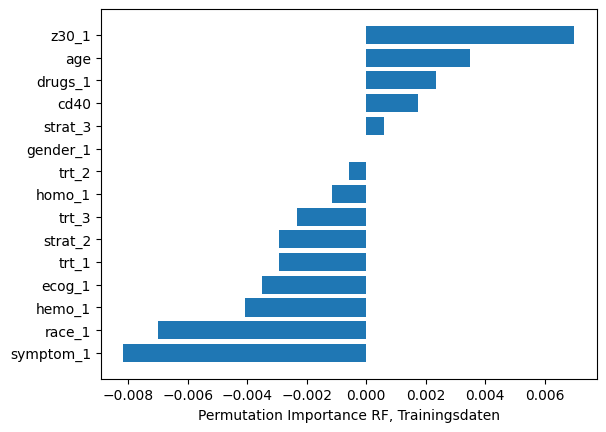

In [19]:
#rf = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
from sklearn.metrics import classification_report
best_rf0.fit(X_train1, y_train1)
y_pred2 = best_rf0.predict(X_test1)
accuracy2 = accuracy_score(y_test1, y_pred2)

print("Trenningsdaten, Akkuranz RF Modell:", accuracy2)

print(classification_report(y_pred2, y_test1))

perm_importance2 = permutation_importance(best_rf0, X_test1, y_test1)

feature_names2 = X_train1.columns
features = np.array(feature_names2)

sorted_idx = perm_importance2.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance2.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance RF, Trainingsdaten")


A negative coefficient means that higher value of the corresponding feature pushes the classification more towards the negative class. 

<span style=color:green> Die möglichen 'low-perform' Features</span> wäre nun `Gender`. 

**`Gender` geht aus der Modellierung raus.**

Außerdem:

`classification_report` für Random Forest liefert maue *Precision* <span style=color:red> für das Target = 1 (failure)</span>. Das ist ein deutlicher Hinweis auf unsymetrische Daten. Auch die Akkuranz ist mittelmässig.

<span style=color:green> Nota bene:</span> `permutation importance` zeigt unterschiedliche, Modell-spezifische Feature-Gewichtung. Daher bringt mich diese Schleife im Entscheidungsprozess nicht weiter, in der Frage - welches Modell für die Prediktion soll gewählt werden. Back to the roots: Entscheidung anhand der Performance-Parameter treffen. ==> Random Forest.

Bevor wir zu dem nächsten Schritt unwichtige Features auszusortiren übergehen, werden noch Mal die Precision und Recall in einer *Confusionsmatrix* dargestellt. SO springt die mittelmässige Leistung des Modells noch besser ins Auge. 

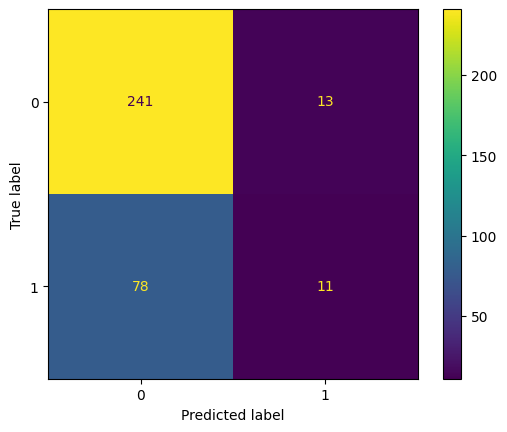

In [20]:
# Generate predictions with the best model
#y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm2 = confusion_matrix(y_test1, y_pred2)

ConfusionMatrixDisplay(cm2).plot();

In [21]:
#Accuracy im Traings- und Validierungsdatensatz
# wie gut wurde getrennt? 

print("Akkuranz Train klein: {}".format(best_rf0.score(X_train1, y_train1)))
print("Akkuranz Test Validierung: {}" .format(best_rf0.score(X_test1, y_test1)))

Akkuranz Train klein: 0.8230994152046783
Akkuranz Test Validierung: 0.7346938775510204


Der Unterschied für Random Forest Akkuranz in den Trainings- und Testdaten (Validierungsdaten) ist schon groß. Das Splitting war nicht ganz optimal?

# Features-Reduktion

Nachfolgend werden die Features anhand von *feature permutation* für das Random Forest und nach inhaltlichen Überlegungen (domane Wissen) aus der weiteren Modellierung entfernt:

`Gender`.

In [22]:
X_train2=X_train.drop(["gender_1"],axis=1)
X_test2=X_test.drop(["gender_1"],axis=1)
y_train2 = y_train.copy()
y_test2 = y_test.copy()


## Hyperparameter für Random Forest

Der Gegencheck für die optimalen Hyperparamter für das Random Forest Modell für den reduzierten Datensatz wird durchgeführt.

In [24]:
# für RF
param_dist = {'n_estimators': randint(10,300),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf1 = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search1 = RandomizedSearchCV(rf1, param_distributions = param_dist, n_iter=5, cv=10, random_state=42)

# Fit the random search object to the data
rand_search1.fit(X_train2, y_train2)

RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000254212F7AC0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000254213270A0>},
                   random_state=42)

In [25]:
best_rf1 = rand_search1.best_estimator_

# Print the best hyperparameters
print('Die optimalen Hyperparameter für RF (Random Search):',  rand_search1.best_params_)

Die optimalen Hyperparameter für RF (Random Search): {'max_depth': 7, 'n_estimators': 280}


In [26]:
#rf2 = RandomForestClassifier(max_depth=7, n_estimators=280, random_state=42)
best_rf1.fit(X_train2, y_train2)
y_pred2 = best_rf1.predict(X_test2)
accuracy3 = accuracy_score(y_test2, y_pred2)

print("Trenningsdaten reduziert, Akkuranz RF Modell:", accuracy3)

print(classification_report(y_pred2, y_test2))

Trenningsdaten reduziert, Akkuranz RF Modell: 0.749271137026239
              precision    recall  f1-score   support

           0       0.96      0.76      0.85       322
           1       0.13      0.57      0.22        21

    accuracy                           0.75       343
   macro avg       0.55      0.67      0.53       343
weighted avg       0.91      0.75      0.81       343



`classification_report` liefert eine **etwas schlechtere** *Precision* und *Supporter* für RF für das Target = 1 (failure).

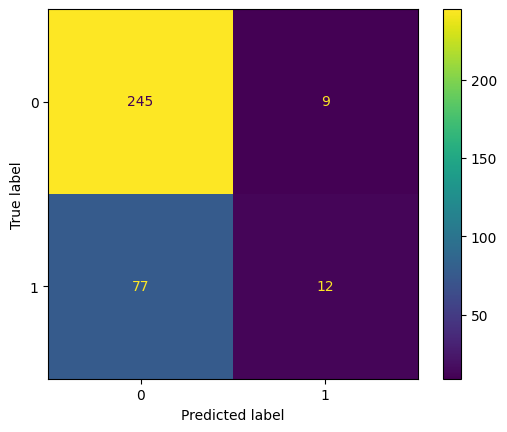

In [27]:
# Create the confusion matrix
cm3 = confusion_matrix(y_test2, y_pred2)

ConfusionMatrixDisplay(cm3).plot();

Text(0.5, 0, 'Permutation Importance RF, reduzierte Trainingsdaten')

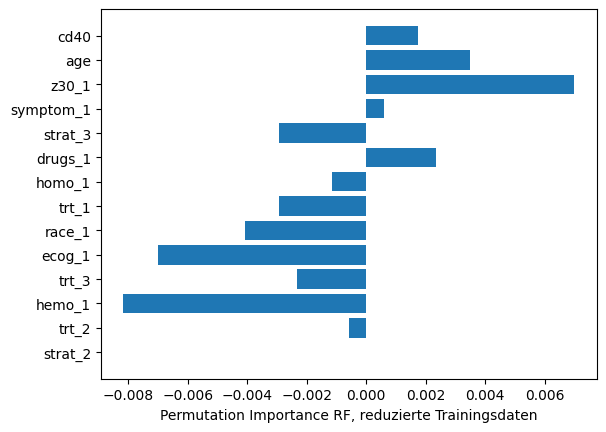

In [28]:
perm_importance3 = permutation_importance(best_rf1, X_test2, y_test2)

feature_names3 = X_train2.columns
features = np.array(feature_names3)

sorted_idx = perm_importance3.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance2.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance RF, reduzierte Trainingsdaten")

# Evaluation des Modells auf Testdaten

In [29]:
X_ftrain=X_fintrain.drop(["gender_1"],axis=1)
X_ftest=X_fintest.drop(["gender_1"],axis=1)
y_ftrain = y_fintrain.copy()
y_ftest = y_fintest.copy()

In [30]:
X_ftrain['age'] = mscaler.transform(X_ftrain['age'].to_numpy().reshape(-1,1))
X_ftrain['cd40'] = mscaler.transform(X_ftrain['cd40'].to_numpy().reshape(-1,1))

In [31]:
rfc = best_rf1.fit(X_ftrain, y_ftrain)
y_pred_fin = best_rf1.predict(X_ftest)
accuracy_fin = accuracy_score(y_ftest, y_pred_fin)

print("Testdaten, Akkuranz Random Forest:", accuracy_fin)

print(classification_report(y_pred_fin, y_ftest))

Testdaten, Akkuranz Random Forest: 0.7616822429906542
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       427
           1       0.00      0.00      0.00         1

    accuracy                           0.76       428
   macro avg       0.50      0.38      0.43       428
weighted avg       0.99      0.76      0.86       428



In [ ]:
import pickle

os
# Modell speichern
file_to_write = open("data/models/random_forest_model.pickle", "wb")
pickle.dump(rfc, file_to_write)

# Modell laden
file_to_open = open("data/models/random_forest_model.pickle", 'rb')
trained_model = pickle.load(file_to_open)
file_to_open.close()

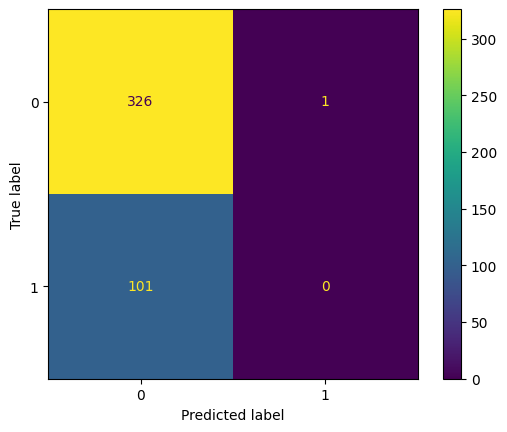

In [32]:
# Create the confusion matrix
cm_fin = confusion_matrix(y_ftest, y_pred_fin)

ConfusionMatrixDisplay(cm_fin).plot();

In [ ]:
#Accuracy im Traings- und Testdatensatz
# wie gut wurde getrennt? Der Unterschied ist relativ groß == mässiger Spliting

print("Akkuranz Random Forest Train: {}".format(best_rf1.score(X_ftrain, y_ftrain)))
print("Akkuranz Random Forest Test: {}" .format(best_rf1.score(X_ftest, y_ftest)))

Akkuranz Random Forest Train: 0.8112215078901227
Akkuranz Random Forest Test: 0.7616822429906542


Es liegt wohl ein Overfitting vor. Die mögliche Lösung wäre:

a. beim Random Forest die maximale Tiefe und die Anzahl der Schätzer zu verringern

oder

b. doch das SVC-rbf Modell trainieren.

Oder

das leistungsschwache Modell auf Fehler evaluieren....  

# Interpretation

feature importance, Reihenfolge der Knoten, Aussagekraft der Prediction.

## Feature Importance

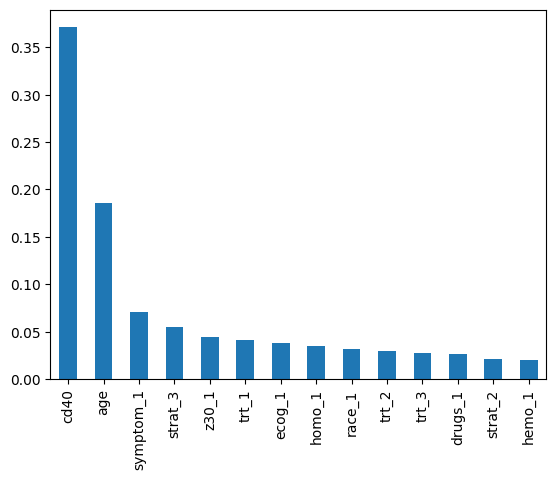

In [34]:
# Create a series containing feature importances from the model and feature names from the training data
fin_feature_importances = pd.Series(best_rf1.feature_importances_, index=X_ftest.columns).sort_values(ascending=False)

# Plot a simple bar chart
fin_feature_importances.plot.bar();

In [35]:
print(fin_feature_importances)

cd40         0.371189
age          0.185933
symptom_1    0.071252
strat_3      0.054686
z30_1        0.044376
trt_1        0.041160
ecog_1       0.038470
homo_1       0.035476
race_1       0.031960
trt_2        0.029501
trt_3        0.027805
drugs_1      0.027025
strat_2      0.021110
hemo_1       0.020056
dtype: float64


## Die ersten drei Trees des Random Forests

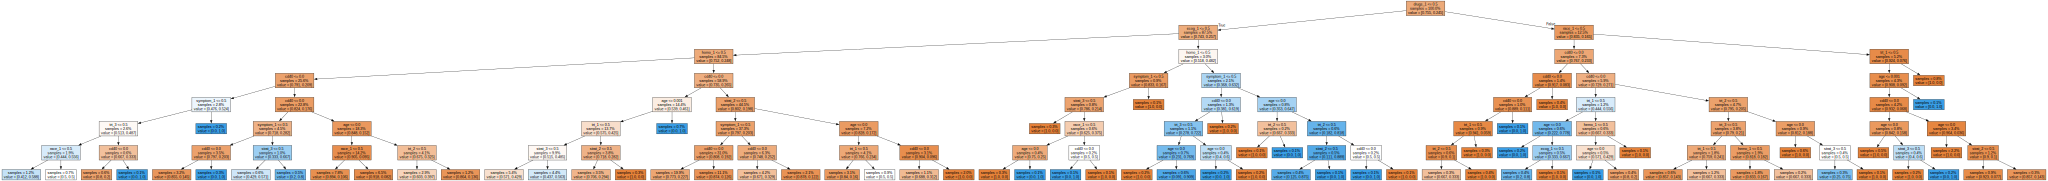

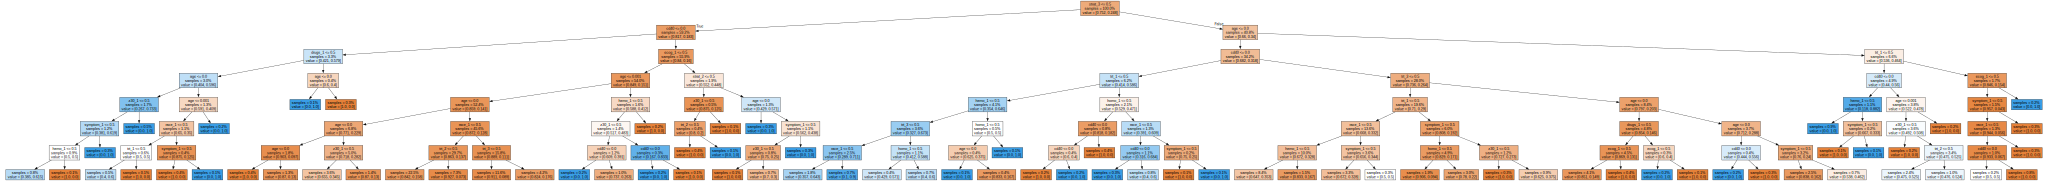

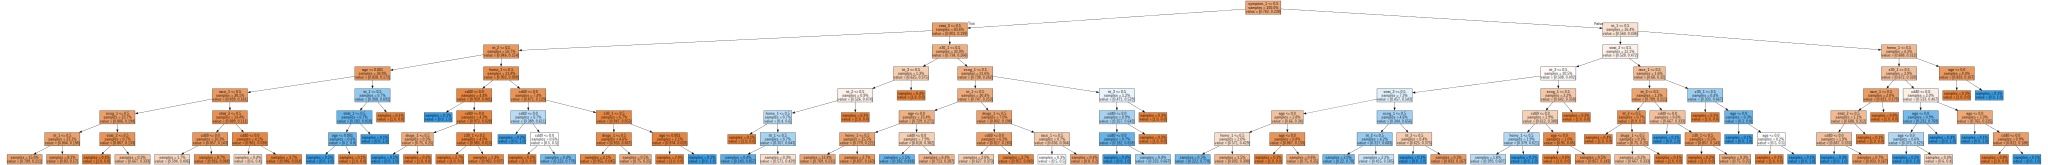

In [36]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = best_rf1.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_ftest.columns,  
                               filled=True,  
                               max_depth=7, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

# Overfitting Problem

In [ ]:
X_test3 = X_test.copy()
X_train3 = X_train.copy()
y_train3 = y_train.copy()
y_test3 = y_test.copy()

              precision    recall  f1-score   support

           0       0.98      0.75      0.85       335
           1       0.04      0.50      0.08         8

    accuracy                           0.74       343
   macro avg       0.51      0.62      0.47       343
weighted avg       0.96      0.74      0.83       343



Text(0.5, 0, 'Permutation Importance RBF SVC, Trainingsdaten')

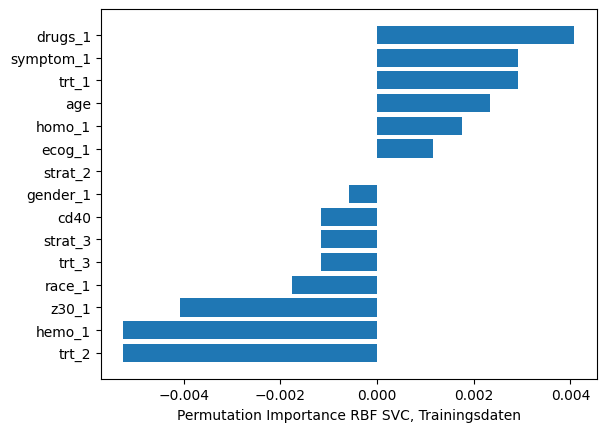

In [ ]:
from sklearn.metrics import classification_report

clf1 =  SVC(kernel='rbf', C=1.5, gamma='scale', random_state=42)
clf1.fit(X_train3, y_train3)
y_pred4 = clf1.predict(X_test3)

print(classification_report(y_pred4, y_test3))

perm_importance4 = permutation_importance(clf1, X_test3, y_test3)

feature_names4 = X_train3.columns
features = np.array(feature_names4)

sorted_idx = perm_importance4.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance4.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance RBF SVC, Trainingsdaten")

#'permutation importance' gibt wieder, wie wichtig ein feature für das vorliegende Modell ist.
# bei RBF sind die 'coef' nicht verfügbar. - keine feature importance.

A negative coefficient means that higher value of the corresponding feature pushes the classification more towards the negative class. 'negative class' ist in diesem Fall 'censoring' also 'überlebt'

In [ ]:
#Accuracy im Traings- und Validierungsdatensatz
# wie gut wurde getrennt? 

print("Akkuranz Train klein: {}".format(clf1.score(X_train3, y_train3)))
print("Akkuranz Validierung: {}" .format(clf1.score(X_test3, y_test3)))

Akkuranz Train klein: 0.7814327485380117
Akkuranz Validierung: 0.7405247813411079


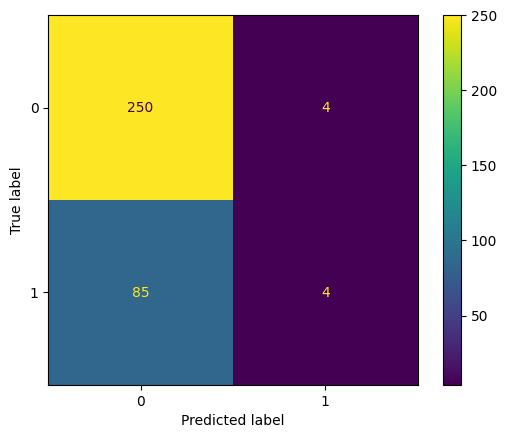

In [ ]:
# Generate predictions with the best model
#y_pred = clf.predict(X_test)

# Create the confusion matrix
cm4 = confusion_matrix(y_test3, y_pred4)

ConfusionMatrixDisplay(cm4).plot();

## Evaluation SVM auf Testdaten

In [ ]:
X_ftrain2 = X_fintrain.copy()
X_ftest2 = X_fintest.copy()
y_ftrain2 = y_fintrain.copy()
y_ftest2 = y_fintest.copy()

In [ ]:
X_ftrain2['age'] = mscaler.transform(X_ftrain2['age'].to_numpy().reshape(-1,1))
X_ftrain2['cd40'] = mscaler.transform(X_ftrain2['cd40'].to_numpy().reshape(-1,1))

              precision    recall  f1-score   support

           0       1.00      0.76      0.87       428
           1       0.00      0.00      0.00         0

    accuracy                           0.76       428
   macro avg       0.50      0.38      0.43       428
weighted avg       1.00      0.76      0.87       428



Text(0.5, 0, 'Permutation Importance RBF SVC, Testdaten')

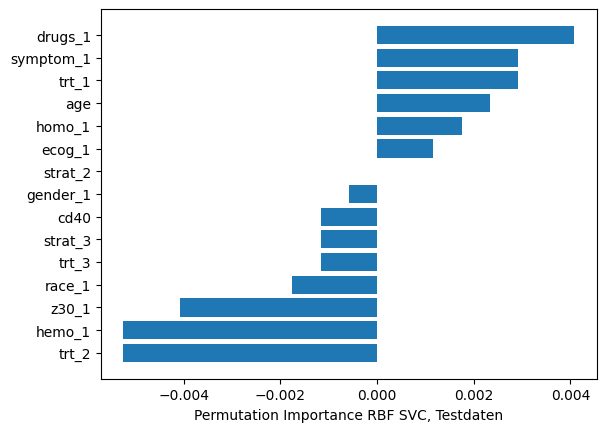

In [ ]:
clf_fin =  SVC(kernel='rbf', C=1.5, gamma='scale', random_state=42)
clf_fin.fit(X_ftrain2, y_ftrain2)
y_pred_fin2 = clf_fin.predict(X_ftest2)

print(classification_report(y_pred_fin2, y_ftest2))

perm_importance_fin2 = permutation_importance(clf_fin, X_ftest2, y_ftest2)

feature_names4 = X_ftrain2.columns
features = np.array(feature_names4)

sorted_idx = perm_importance4.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance4.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance RBF SVC, Testdaten")


Großes Kino. Das Modell prediktet nicht für Target = 1.
Keine Zeit mehr für die Lösungssuche. <span style=color:red>Deadline naht.</span>

Fazit: **Fehler evaluieren, Limitationen aufzeigen.** Evtl. sind die z.B. Box-Plot Unterschiede zwischen `Alter` und `Drogen` bzw. `Race` doch relevant genug. 


Hier müsste man nun den kompletten sogenannten *Table 1* auf Signifikanzen in Treatment-Gruppen testen.